In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw 
tf.enable_eager_execution()

/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
from syn_dataset import SynDataset
from adl_dataset import ADLDataset
from ecg_dataset import ECGDataset
from data_utils import DataFactory

/home/malzantot/Nesl/bio_gan/ecg_dataset.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/malzantot/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/malzantot/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loo

In [4]:
batch_size = 100


def get_distances(batch_x):
    batch_size = batch_x.shape[0]
    dist_list = []
    for i in range(batch_size):
        min_dist = 10000000
        for j in range(batch_size):
            if i == j:
                continue
            d, path = fastdtw(batch_x[i], batch_x[j], dist=euclidean)
            min_dist = min(d, min_dist)
            dist_list.append(min_dist)
    return np.array(dist_list)

In [5]:
def get_diversity_score(dset_name, fake_data_list, batch_size=100):
    real_train, real_test, metadata = DataFactory.create_dataset(dset_name)
    real_set = real_train.shuffle(batch_size).batch(batch_size)
    real_batch_x, real_batch_y = next(iter(real_set))
    real_batch_x = real_batch_x.numpy()
    real_batch_y = real_batch_y.numpy()
    real_dist_list = get_distances(real_batch_x)
    normalizer = np.mean(real_dist_list)
    real_score = np.mean(real_dist_list/normalizer)
    
    result = []
    result.append(('real', real_score, real_dist_list))
    for  fake_path, fake_name in fake_data_list:
        fake_set = SynDataset(fake_path, None)
        fake_set = fake_set.to_dataset().shuffle(1000).batch(batch_size)
        syn_batch_x, syn_batch_y = next(iter(fake_set))
        syn_batch_x = syn_batch_x.numpy()
        syn_batch_y = syn_batch_y.numpy()
        fake_dist_list = get_distances(syn_batch_x)
        fake_dist_normalized = fake_dist_list / normalizer
        score = np.mean(fake_dist_normalized)
        result.append((fake_name, score, fake_dist_list))
    return result
    

In [6]:
dataset_name = 'ecg'
fake_data = [
    ('samples/ecg_crnn/08_01_22_13', 'CRNN'),
    ('samples/ecg_crvae/07_29_13_10', 'CVRAE'),
    #('samples/ecg_rgan/07_30_22_02', 'RGAN'),
    #('samples/ecg_rganar/07_30_22_03', 'RGAN-AR'),
    #('samples/ecg_physgan/07_27_21_11', 'PhisyoGAN'),
    
]

In [7]:
result = get_diversity_score(dataset_name, fake_data, 1000)

['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([211, 102]))
['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([72, 33]))


In [9]:
for (method, score, _) in result:
    print('{} - {:.2f}'.format(method, score))

real - 1.00
CRNN - 1.03
CVRAE - 1.01


/home/malzantot/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


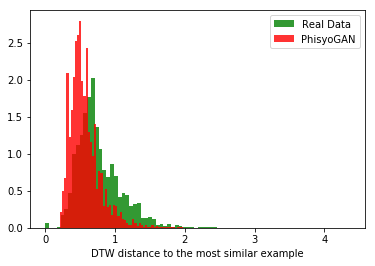

In [26]:
plt.hist(result[0][2], color='green', normed=True, cumulative=False, bins=80,alpha=0.8, label='Real Data')
plt.hist(result[-1][2], color='red', normed=True, cumulative=False, bins=80,alpha=0.8,label='PhisyoGAN')
plt.xlabel('DTW distance to the most similar example')
plt.legend()
plt.savefig('diversity_dist.png')
None

In [ ]:
DT